<h2>Start Spark Session</h2>

In [190]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession, SQLContext

In [191]:
import matplotlib.pyplot as plt
import seaborn as sns

In [192]:
import pyspark.sql.functions as F

In [193]:
spark = SparkSession.builder.master('local').appName('Airbnb Rental price').getOrCreate()

<h2>Data Ingestion and Exploration</h2>

In [194]:
filepath = 'data/sf-airbnb/parquet'
airbnbDF = spark.read.parquet(filepath)

airbnbDF.printSchema()

root
 |-- summary: string (nullable = true)
 |-- space: string (nullable = true)
 |-- description: string (nullable = true)
 |-- neighborhood_overview: string (nullable = true)
 |-- transit: string (nullable = true)
 |-- access: string (nullable = true)
 |-- house_rules: string (nullable = true)
 |-- host_since: string (nullable = true)
 |-- host_response_time: integer (nullable = true)
 |-- host_response_rate: double (nullable = true)
 |-- host_is_superhost: string (nullable = true)
 |-- host_neighbourhood: string (nullable = true)
 |-- host_total_listings_count: double (nullable = true)
 |-- host_verifications: string (nullable = true)
 |-- host_has_profile_pic: string (nullable = true)
 |-- host_identity_verified: string (nullable = true)
 |-- neighbourhood_cleansed: string (nullable = true)
 |-- zipcode: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: double (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- bedrooms: double (nullab

In [195]:
# For now, I deleted some columns with text

remove_cols = ['summary', 'space', 'description', 'neighborhood_overview', 'transit', 'access'
                , 'house_rules', 'host_since', 'host_response_time', 'host_response_rate'
                , 'host_neighbourhood', 'host_verifications', 'zipcode'
                , 'neighbourhood_cleansed', 'amenities', 'security_deposit', 'cleaning_fee'
                , 'guests_included', 'extra_people', 'number_of_reviews', 'license']

In [196]:
df = airbnbDF.drop(*remove_cols)

df.head(1)

[Row(host_is_superhost='t', host_total_listings_count=1.0, host_has_profile_pic='t', host_identity_verified='t', room_type='Entire home/apt', accommodates=3.0, bathrooms=1.0, bedrooms=1.0, beds=2.0, price=170.0, number_of_reviews_ltm=52.0, review_scores_rating=97.0, review_scores_accuracy=10.0, review_scores_cleanliness=10.0, review_scores_checkin=10.0, review_scores_communication=10.0, review_scores_location=10.0, review_scores_value=10.0, instant_bookable='t', cancellation_policy='moderate', require_guest_profile_picture='f', require_guest_phone_verification='f', calculated_host_listings_count=1.0)]

In [197]:
df.printSchema()

root
 |-- host_is_superhost: string (nullable = true)
 |-- host_total_listings_count: double (nullable = true)
 |-- host_has_profile_pic: string (nullable = true)
 |-- host_identity_verified: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: double (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- beds: double (nullable = true)
 |-- price: double (nullable = true)
 |-- number_of_reviews_ltm: double (nullable = true)
 |-- review_scores_rating: double (nullable = true)
 |-- review_scores_accuracy: double (nullable = true)
 |-- review_scores_cleanliness: double (nullable = true)
 |-- review_scores_checkin: double (nullable = true)
 |-- review_scores_communication: double (nullable = true)
 |-- review_scores_location: double (nullable = true)
 |-- review_scores_value: double (nullable = true)
 |-- instant_bookable: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- require

In [198]:
# Null value check
null_dict = dict()

for col in df.columns:
    null_dict[col] = df.select(col).where(F.col(col).isNull()).count()
    
null_dict

{'host_is_superhost': 0,
 'host_total_listings_count': 0,
 'host_has_profile_pic': 0,
 'host_identity_verified': 0,
 'room_type': 0,
 'accommodates': 0,
 'bathrooms': 21,
 'bedrooms': 2,
 'beds': 7,
 'price': 0,
 'number_of_reviews_ltm': 0,
 'review_scores_rating': 1421,
 'review_scores_accuracy': 1425,
 'review_scores_cleanliness': 1424,
 'review_scores_checkin': 1427,
 'review_scores_communication': 1423,
 'review_scores_location': 1427,
 'review_scores_value': 1428,
 'instant_bookable': 0,
 'cancellation_policy': 0,
 'require_guest_profile_picture': 0,
 'require_guest_phone_verification': 0,
 'calculated_host_listings_count': 0}

In [203]:
''' 
For the future purpose
select columns with a string type
select columns with a numerical type (in this case, double type)
'''

cat_cols = [field for (field, dataType) in df.dtypes if dataType == 'string']
num_cols = [field for (field, dataType) in df.dtypes if ((dataType=='double') & (field !='price'))]

<h3>Dealing with null values : Here, I will use Imputer for numerical features with means.</h3>

In [200]:
# Imputer
from pyspark.ml.feature import Imputer

In [204]:
imputer = Imputer(inputCols=num_cols, outputCols=num_cols)

imputed_df = imputer.fit(df).transform(df)

In [205]:
# Null value check
null_dict = dict()

for col in imputed_df.columns:
    null_dict[col] = imputed_df.select(col).where(F.col(col).isNull()).count()
    
null_dict

{'host_is_superhost': 0,
 'host_total_listings_count': 0,
 'host_has_profile_pic': 0,
 'host_identity_verified': 0,
 'room_type': 0,
 'accommodates': 0,
 'bathrooms': 0,
 'bedrooms': 0,
 'beds': 0,
 'price': 0,
 'number_of_reviews_ltm': 0,
 'review_scores_rating': 0,
 'review_scores_accuracy': 0,
 'review_scores_cleanliness': 0,
 'review_scores_checkin': 0,
 'review_scores_communication': 0,
 'review_scores_location': 0,
 'review_scores_value': 0,
 'instant_bookable': 0,
 'cancellation_policy': 0,
 'require_guest_profile_picture': 0,
 'require_guest_phone_verification': 0,
 'calculated_host_listings_count': 0}

In [206]:
# Creating Training and Test Data sets
trainDF, testDF = imputed_df.randomSplit([0.8, 0.2], seed = 42)

print(f'There are {trainDF.count()} rows in the training set, and {testDF.count()} in the test set')

There are 5784 rows in the training set, and 1367 in the test set


<h2>Build Simple Pipeline: Vectorassembler + linear Regression</h2>

In [233]:
# Preparing features with transformers

vecAssembler = VectorAssembler(inputCols=['bedrooms', 'beds'], outputCol='features')

# To see the result of vector assembler
vecTrainDF = vecAssembler.transform(trainDF)
vecTrainDF.select('bedrooms', 'beds', 'features', 'price').show(5)

+--------+----+---------+-----+
|bedrooms|beds| features|price|
+--------+----+---------+-----+
|     1.0| 1.0|[1.0,1.0]|200.0|
|     2.0| 2.0|[2.0,2.0]|199.0|
|     3.0| 3.0|[3.0,3.0]|750.0|
|     1.0| 1.0|[1.0,1.0]|194.0|
|     0.0| 1.0|[0.0,1.0]| 60.0|
+--------+----+---------+-----+
only showing top 5 rows



In [234]:
# Linear Regression with MLlib
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol='features', labelCol='price')

In [235]:
# Build a Pipeline
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[vecAssembler, lr])
pipelineModel = pipeline.fit(trainDF)

In [237]:
testDF.select('bedrooms', 'beds').show(5)

+--------+----+
|bedrooms|beds|
+--------+----+
|     3.0| 3.0|
|     0.0| 1.0|
|     1.0| 1.0|
|     0.0| 1.0|
|     0.0| 1.0|
+--------+----+
only showing top 5 rows



In [240]:
# make a prediction
predDF = pipelineModel.transform(testDF)

predDF.select('features', 'price', 'prediction').show(10)

+---------+-----+------------------+
| features|price|        prediction|
+---------+-----+------------------+
|[3.0,3.0]|300.0|405.92479213858223|
|[0.0,1.0]| 88.0| 64.44509135229788|
|[1.0,1.0]| 75.0|160.30399613836227|
|[0.0,1.0]| 95.0| 64.44509135229788|
|[0.0,1.0]|112.0| 64.44509135229788|
|[0.0,1.0]|115.0| 64.44509135229788|
|[0.0,1.0]|140.0| 64.44509135229788|
|[0.0,1.0]|200.0| 64.44509135229788|
|[1.0,1.0]| 89.0|160.30399613836227|
|[1.0,1.0]| 90.0|160.30399613836227|
+---------+-----+------------------+
only showing top 10 rows



In [239]:
# Evaluate our model
from pyspark.ml.evaluation import RegressionEvaluator

regressionEvaluator = RegressionEvaluator(
                        predictionCol = 'prediction',
                        labelCol = 'price',
                        metricName = 'rmse'
                        )

rmse = regressionEvaluator.evaluate(predDF)


print(f'RMSE is {rmse}')

RMSE is 313.71548371860786


In [244]:
df.select('price').summary().show()

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|              7151|
|   mean| 213.6540344007831|
| stddev|313.28222046853125|
|    min|               0.0|
|    25%|             100.0|
|    50%|             150.0|
|    75%|           10000.0|
|    max|           10000.0|
+-------+------------------+



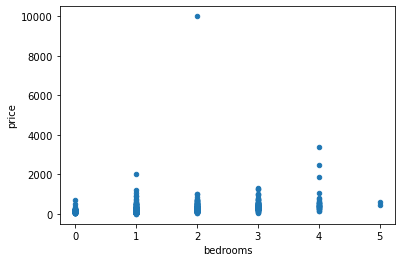

In [245]:
bed_price_df = testDF.select('bedrooms', 'price').toPandas()
bed_price_df.plot.scatter('bedrooms', 'price')

In [248]:
# We have outlier here
# I am curious what happens if I delete that outlier
# Linear regression is basically weak to outliers

testDF.select('bedrooms', 'price').where(testDF.price > 8000).show()

+--------+-------+
|bedrooms|  price|
+--------+-------+
|     2.0|10000.0|
+--------+-------+



In [247]:
test_testDF = testDF.filter(testDF.price < 8000)

In [250]:
# make a prediction
predDF = pipelineModel.transform(test_testDF)

predDF.select('features', 'price', 'prediction').show(5)

+---------+-----+------------------+
| features|price|        prediction|
+---------+-----+------------------+
|[3.0,3.0]|300.0|405.92479213858223|
|[0.0,1.0]| 88.0| 64.44509135229788|
|[1.0,1.0]| 75.0|160.30399613836227|
|[0.0,1.0]| 95.0| 64.44509135229788|
|[0.0,1.0]|112.0| 64.44509135229788|
+---------+-----+------------------+
only showing top 5 rows



In [251]:
# Evaluate our model
from pyspark.ml.evaluation import RegressionEvaluator

regressionEvaluator = RegressionEvaluator(
                        predictionCol = 'prediction',
                        labelCol = 'price',
                        metricName = 'rmse'
                        )

rmse = regressionEvaluator.evaluate(predDF)


print(f'RMSE is {rmse}')

RMSE is 174.68544495844938


<h3>We can see that one outlier lower the performance of a regression model</h3>

<h3>Test of dropping null values instead of imputing with mean</h3>

In [223]:
droped_df = df.dropna(subset=('bedrooms', 'bathrooms', 'beds'))

In [224]:
# Creating Training and Test Data sets
d_trainDF, d_testDF = imputed_df.randomSplit([0.8, 0.2], seed = 42)

print(f'There are {d_trainDF.count()} rows in the training set, and {d_testDF.count()} in the test set')

There are 5784 rows in the training set, and 1367 in the test set


In [228]:
# Preparing features with transformers

d_vecAssembler = VectorAssembler(inputCols=['bedrooms'], outputCol='features')

# To see the result of vector assembler
d_vecTrainDF = d_vecAssembler.transform(d_trainDF)
d_vecTrainDF.select('bedrooms', 'bathrooms', 'features', 'price').show(5)

+--------+---------+--------+-----+
|bedrooms|bathrooms|features|price|
+--------+---------+--------+-----+
|     1.0|      1.0|   [1.0]|200.0|
|     2.0|      2.0|   [2.0]|199.0|
|     3.0|      1.5|   [3.0]|750.0|
|     1.0|      0.5|   [1.0]|194.0|
|     0.0|      1.0|   [0.0]| 60.0|
+--------+---------+--------+-----+
only showing top 5 rows



In [229]:
# Linear Regression with MLlib

d_lr = LinearRegression(featuresCol='features', labelCol='price')

In [230]:
d_pipeline = Pipeline(stages=[d_vecAssembler, d_lr])
d_pipelineModel = d_pipeline.fit(trainDF)

In [231]:
# make a prediction
d_predDF = d_pipelineModel.transform(d_testDF)

d_predDF.select('features', 'price', 'prediction').show(5)

+--------+-----+------------------+
|features|price|        prediction|
+--------+-----+------------------+
|   [3.0]|300.0| 414.5102931306073|
|   [0.0]| 88.0|51.081508941708364|
|   [1.0]| 75.0|172.22443700467468|
|   [0.0]| 95.0|51.081508941708364|
|   [0.0]|112.0|51.081508941708364|
+--------+-----+------------------+
only showing top 5 rows



In [232]:
d_regressionEvaluator = RegressionEvaluator(
                        predictionCol = 'prediction',
                        labelCol = 'price',
                        metricName = 'rmse'
                        )

d_rmse = regressionEvaluator.evaluate(d_predDF)


print(f'RMSE is {d_rmse}')

RMSE is 315.279104840011


In [252]:
# This does not improve my model

<h3>Test End</h3>

### Build a pipeline with whole variables

In [253]:
'''
1. categorical columns: use StringIndexer to change string values to numerical values
2. numerical columns: use StandardScaler to normalize each feature
'''

from pyspark.ml.feature import StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml import Pipeline

# index column to use for StringIndexer
index_cols = [col + '_idx' for col in cat_cols]
# scaler column to use for StandardScaler
scaled_cols = [col +'scaled' for col in num_cols]

# StringIndexer
stringIndexer = StringIndexer(inputCols=cat_cols, outputCols=index_cols, handleInvalid='skip')


assemblerinput = index_cols + num_cols

# Vector Assembler 
# : combines a given list of columns into a single vector column
vectorassembler = VectorAssembler(inputCols= assemblerinput, outputCol = 'features')

In [279]:
pipeline = Pipeline(stages=[stringIndexer] + [vectorassembler, lr])

pipelinemodel = pipeline.fit(trainDF)

transformed_df = pipelinemodel.transform(trainDF).select('features')

In [266]:
# Make a prediction

predDF = pipelinemodel.transform(testDF)

predDF.select('features', 'price', 'prediction').show(5)

+--------------------+-----+------------------+
|            features|price|        prediction|
+--------------------+-----+------------------+
|[0.0,1.0,1.0,0.0,...|300.0|395.52140314661875|
|[0.0,0.0,1.0,0.0,...| 88.0| 96.07741743093254|
|[0.0,0.0,1.0,0.0,...| 75.0|144.00722502266694|
|[0.0,0.0,1.0,0.0,...| 95.0| 99.58956709605081|
|[0.0,0.0,1.0,0.0,...|112.0| 65.20471975679345|
+--------------------+-----+------------------+
only showing top 5 rows



In [269]:
regressionEvaluator = RegressionEvaluator(
                        predictionCol = 'prediction',
                        labelCol = 'price',
                        metricName = 'rmse'
                        )

# Root mean square Error
rmse = regressionEvaluator.evaluate(predDF)
# Mean Absolute Error
mae = regressionEvaluator.setMetricName('mse').evaluate(predDF)
# R2
r2 = regressionEvaluator.setMetricName('r2').evaluate(predDF)


print(f'RMSE is {rmse}')
print(f'MAE is {mae}')
print(f'R2 is {r2}')

RMSE is 308.933481062648
MAE is 95439.8957214855
R2 is 0.131640883814381


In [272]:
# Compare with a training error
pred_train = pipelinemodel.transform(trainDF)
rmse_train = regressionEvaluator.setMetricName('rmse').evaluate(pred_train)

print(rmse_train)

279.1798621210535


### StandardScaler

In [310]:
# StandardScaler
standardscaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=False)

lr = LinearRegression(featuresCol='scaled_features', labelCol='price')

pipeline_w_scaler = Pipeline(stages = [stringIndexer, vectorassembler, standardscaler, lr])

pipelineModel_w_scaler = pipeline_w_scaler.fit(trainDF)

In [320]:
pipelineModel_w_scaler.transform(trainDF).select('scaled_features').head(3)

[Row(scaled_features=DenseVector([0.0, 0.0, 2.0194, 1.8461, 0.0, 2.395, 0.0, 0.0, 0.0, 1.034, 1.2359, 1.0596, 0.846, 0.044, 16.2332, 17.3045, 14.7337, 22.9797, 18.7166, 15.8359, 14.3313, 0.0249])),
 Row(scaled_features=SparseVector(22, {5: 1.1975, 9: 2.068, 10: 2.4719, 11: 2.1192, 12: 1.6919, 14: 16.2332, 15: 15.5741, 16: 14.7337, 17: 22.9797, 18: 16.8449, 19: 15.8359, 20: 12.8982, 21: 0.0249})),
 Row(scaled_features=DenseVector([0.0, 16.244, 2.0194, 0.0, 0.0, 2.395, 0.0, 0.0, 0.0057, 3.102, 1.8539, 3.1788, 2.5379, 0.1758, 16.2332, 17.3045, 14.7337, 22.9797, 18.7166, 15.8359, 11.465, 0.0249]))]

In [311]:
pred_w_scaler = pipelineModel_w_scaler.transform(testDF)

In [312]:
regressionEvaluator = RegressionEvaluator(
                        predictionCol = 'prediction',
                        labelCol = 'price',
                        metricName = 'rmse'
                        )

# Root mean square Error
rmse = regressionEvaluator.evaluate(pred_w_scaler )
# Mean Absolute Error
mae = regressionEvaluator.setMetricName('mse').evaluate(pred_w_scaler )
# R2
r2 = regressionEvaluator.setMetricName('r2').evaluate(pred_w_scaler )


print(f'RMSE is {rmse}')
print(f'MAE is {mae}')
print(f'R2 is {r2}')

RMSE is 308.933481062616
MAE is 95439.89572146574
R2 is 0.13164088381456085


### End : Nothing has been improved

### MinMaxScaler

In [321]:
from pyspark.ml.feature import MinMaxScaler

In [322]:
# ImMaxScaler
# by default, Min=0, Max=1

scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')

In [325]:
pipeline_w_scaler = Pipeline(stages = [stringIndexer, vectorassembler, scaler, lr])

pipelineModel_w_scaler = pipeline_w_scaler.fit(trainDF)

pred_w_scaler = pipelineModel_w_scaler.transform(testDF)

In [326]:
pipelineModel_w_scaler.transform(trainDF).select('scaled_features').head(3)

[Row(scaled_features=DenseVector([0.0, 0.0, 1.0, 0.5, 0.0, 0.4, 0.0, 0.0, 0.0, 0.0667, 0.0714, 0.0714, 0.0714, 0.0066, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0])),
 Row(scaled_features=SparseVector(22, {5: 0.2, 9: 0.2, 10: 0.1429, 11: 0.1429, 12: 0.1429, 14: 1.0, 15: 0.875, 16: 1.0, 17: 1.0, 18: 0.875, 19: 1.0, 20: 0.875})),
 Row(scaled_features=DenseVector([0.0, 1.0, 1.0, 0.0, 0.0, 0.4, 0.0, 0.0, 0.0008, 0.3333, 0.1071, 0.2143, 0.2143, 0.0263, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 0.0]))]

In [327]:
regressionEvaluator = RegressionEvaluator(
                        predictionCol = 'prediction',
                        labelCol = 'price',
                        metricName = 'rmse'
                        )

# Root mean square Error
rmse = regressionEvaluator.evaluate(pred_w_scaler )
# Mean Absolute Error
mae = regressionEvaluator.setMetricName('mse').evaluate(pred_w_scaler )
# R2
r2 = regressionEvaluator.setMetricName('r2').evaluate(pred_w_scaler )


print(f'RMSE is {rmse}')
print(f'MAE is {mae}')
print(f'R2 is {r2}')

RMSE is 308.9334810626644
MAE is 95439.8957214956
R2 is 0.13164088381428918


### END - Nothing has been improved

In [328]:
'''
save this dataset for future use (I do this work with other ML models)
'''

imputed_df.write.format('parquet') \
    .mode('overwrite') \
    .option('compression', 'snappy')\
    .save('data/sf-airbnb/imputed_parquet')